In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

### Construct multidimensional data for regression
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html

In [38]:
n = 1000
intercept = np.random.randint(low= 5, high= 20)
X, y, w = make_regression(n_samples= n, 
                          n_features= 10, 
                          n_informative= 6, 
                          coef= True,
                          bias = intercept,
                          noise = 0)

#### Examine shape of input data $X$
$X$ will have shape $n \times n\_features$

In [39]:
X.shape

(1000, 10)

#### Examine values in coefficient array $w$
$w$ will have $n\_features$ of elements, but only $n\_informative$ will be non-zero

In [40]:
print(w)

[90.52931875 73.21305869  0.          3.99328829  0.          0.
 31.2060589  82.94870214  0.         56.55440776]


### Examine data
Notice all features follow a normal distribution centered around zero

In [41]:
temp = pd.DataFrame(X)
temp['target'] = y

temp.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1000.0,-0.007053,1.008143,-2.989446,-0.653586,0.004930,0.680409,3.261421
1,1000.0,0.016785,0.994546,-3.587034,-0.662656,0.005934,0.700530,2.707763
2,1000.0,0.015677,0.985411,-3.020250,-0.598698,0.006171,0.708069,3.027092
3,1000.0,0.071694,0.989435,-2.889396,-0.577061,0.060473,0.733446,3.042104
4,1000.0,0.007201,0.992410,-2.900308,-0.649682,0.023185,0.668309,3.376806
5,1000.0,0.014584,0.971795,-2.939147,-0.673047,0.013266,0.679662,3.720323
6,1000.0,0.035127,0.956515,-2.815281,-0.659886,0.057264,0.679510,3.306692
7,1000.0,-0.025383,0.994539,-3.032437,-0.712464,0.020211,0.611836,2.857716
8,1000.0,0.042038,0.978450,-2.811437,-0.682523,0.046137,0.715037,3.057057
9,1000.0,-0.026568,1.021236,-4.608529,-0.723720,-0.050286,0.661050,2.586266


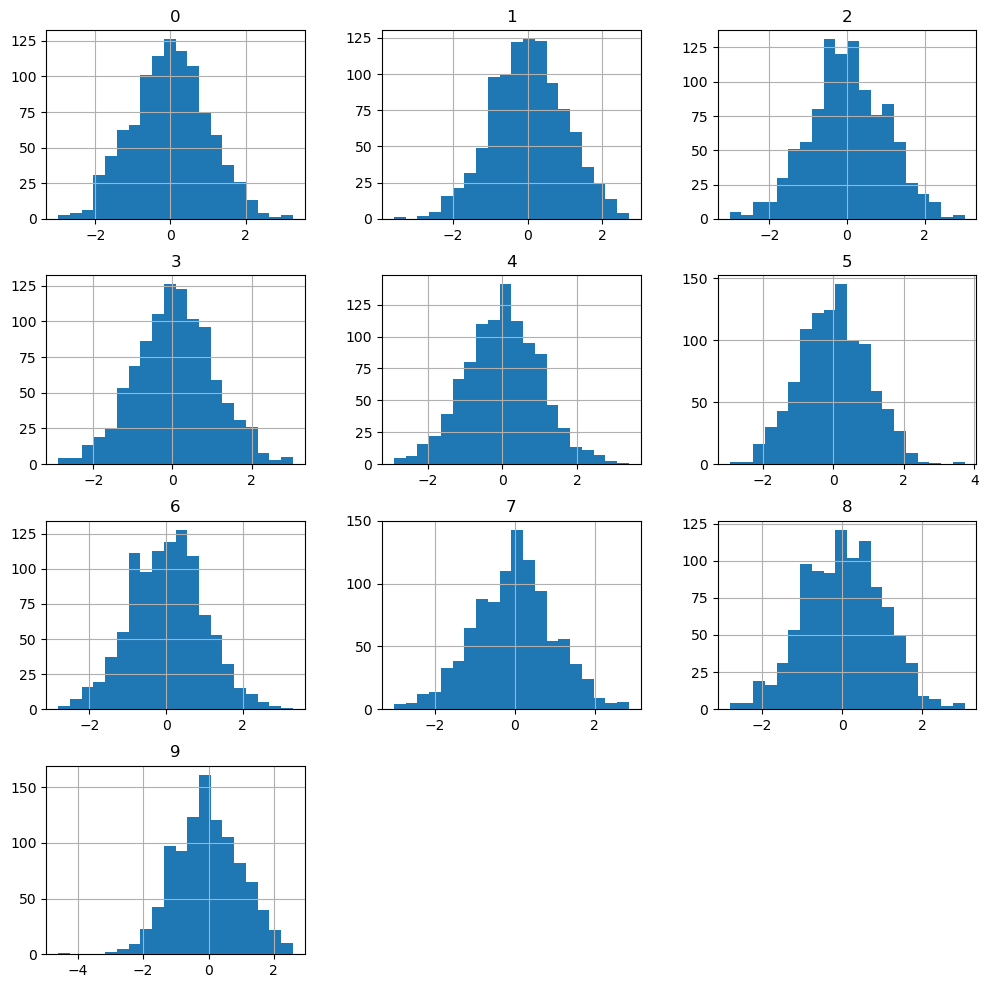

In [42]:
temp.drop(columns= 'target').hist(bins= 20, figsize=(12, 12));

### Correlation Matrix
Notice:
- there is no correlation amongst features
- only the informative features are correlated to the target

In [43]:
corr_mtrx = temp.corr()

corr_feats_ordered = corr_mtrx.drop('target')['target'].abs().sort_values(ascending= False).index

corr_mtrx.drop('target')['target'][corr_feats_ordered]

0    0.607678
7    0.503714
1    0.429096
9    0.374898
6    0.142776
2   -0.033345
5   -0.029377
8    0.026417
3    0.022449
4    0.018966
Name: target, dtype: float64

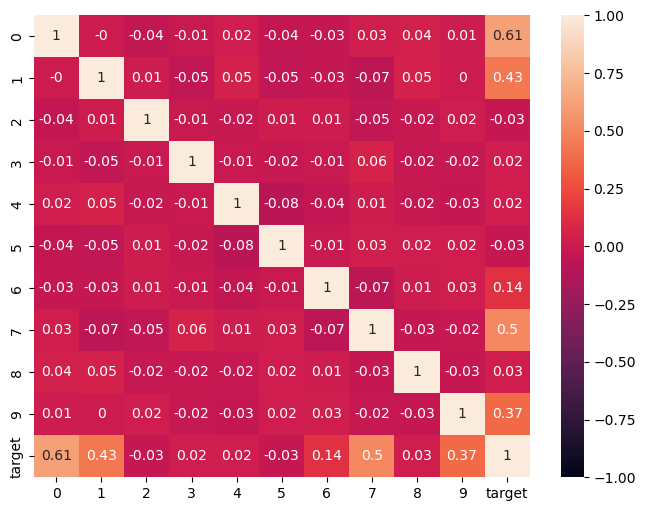

In [44]:
fig = plt.figure(figsize= (8, 6))
sns.heatmap(corr_mtrx.round(2), annot= True, vmin= -1, vmax= 1)
plt.show()

### Train-Test splitting

In [45]:
X_train, X_test, y_train, y_test = train_test_split(temp.drop(columns= ['target']), 
                                                    temp['target'],
                                                    test_size= 0.20, 
                                                    random_state= 303)

### Examine the coefficient weights as regularization strength is increased

In [46]:
ridge = Ridge()
ridge_coefs = []
ridge_errors = []

lasso = Lasso()
lasso_coefs = []
lasso_errors = []


alphas = np.logspace(0, 5, 200)
for a in alphas:
    ridge.set_params(alpha= a)
    ridge.fit(X_train, y_train)
    ridge_coefs.append(np.append(ridge.intercept_, ridge.coef_))
    ridge_errors.append(np.sqrt(mean_squared_error(y_true= y_test, y_pred= ridge.predict(X_test))))
    
    lasso.set_params(alpha= a)
    lasso.fit(X_train, y_train)
    lasso_coefs.append(np.append(lasso.intercept_, lasso.coef_))
    lasso_errors.append(np.sqrt(mean_squared_error(y_true= y_test, y_pred= lasso.predict(X_test))))

In [47]:
print('Actual\t\t Ridge\t\t Lasso')
print(f'{intercept} \t\t {np.round(ridge_coefs[0][0], 4)} \t {np.round(lasso_coefs[0][0], 4)}')

for i in np.arange(ridge_coefs[0][1:].shape[0]):
    print(f'{np.round(w[i], 3)} \t\t {np.round(ridge_coefs[0][i+1], 4)} \t {np.round(lasso_coefs[0][i+1], 4)}')

Actual		 Ridge		 Lasso
15 		 14.9945 	 15.0033
90.529 		 90.418 	 89.5637
73.213 		 73.1099 	 72.0255
0.0 		 -0.0081 	 -0.0
3.993 		 3.9923 	 2.9776
0.0 		 0.0041 	 0.0
0.0 		 -0.0073 	 -0.0
31.206 		 31.1492 	 30.0016
82.949 		 82.8285 	 81.78
0.0 		 0.006 	 0.0
56.554 		 56.4847 	 55.5647


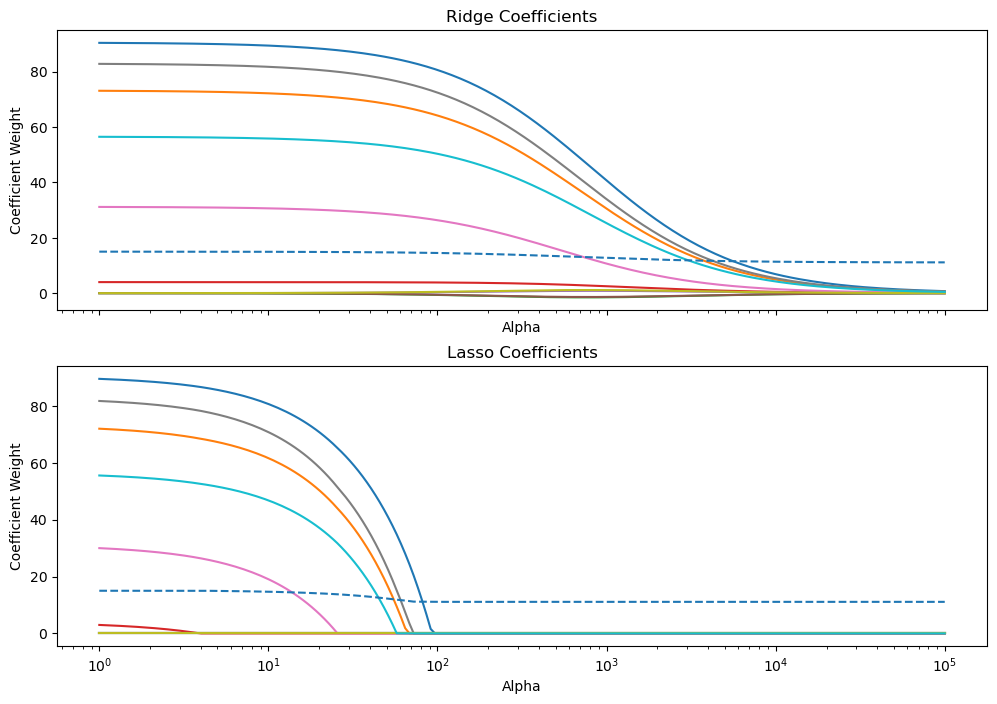

In [48]:
# Display results

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex= True)

ax1.plot(alphas, np.array(ridge_coefs)[:, 1:])
ax1.plot(alphas, np.array(ridge_coefs)[:, 0], '--')
ax1.set_title('Ridge Coefficients')
ax1.set_xscale("log")
ax1.set_ylabel("Coefficient Weight")
ax1.set_xlabel("Alpha")

ax2.plot(alphas, np.array(lasso_coefs)[:, 1:])
ax2.plot(alphas, np.array(lasso_coefs)[:, 0], '--')
ax2.set_title('Lasso Coefficients')
ax2.set_xscale("log")
ax2.set_ylabel("Coefficient Weight")
ax2.set_xlabel("Alpha")

plt.show()

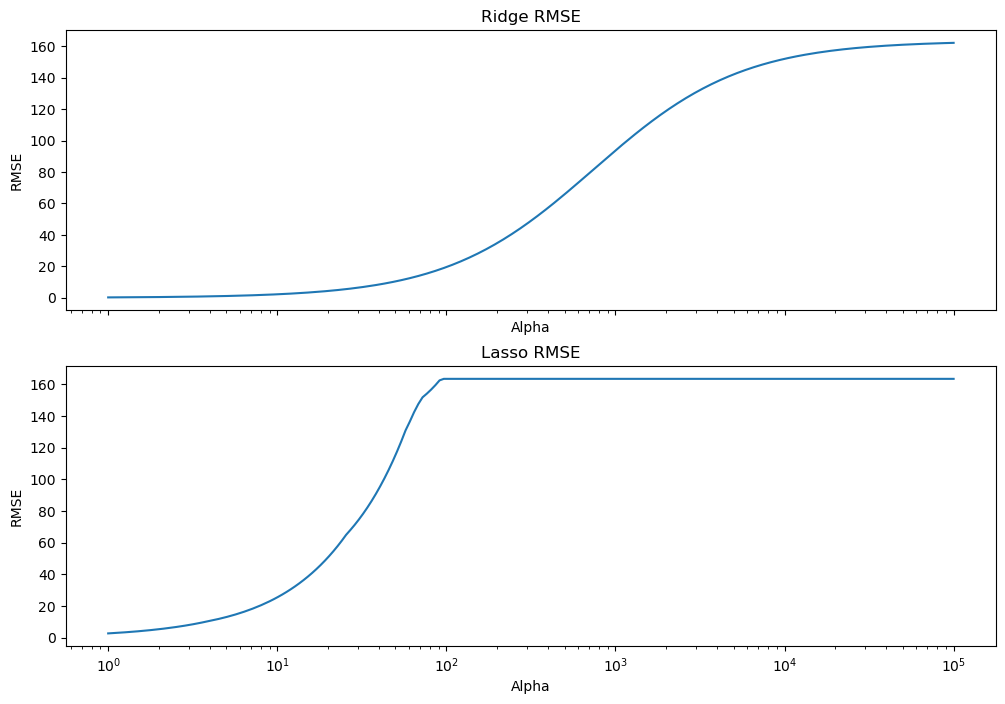

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex= True)

ax1.plot(alphas, ridge_errors)
ax1.set_title('Ridge RMSE')
ax1.set_xscale("log")
ax1.set_ylabel("RMSE")
ax1.set_xlabel("Alpha")

ax2.plot(alphas, lasso_errors)
ax2.set_title('Lasso RMSE')
ax2.set_xscale("log")
ax2.set_ylabel("RMSE")
ax2.set_xlabel("Alpha")

plt.show()